In [248]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [280]:
vids.shape

(1088, 23)

In [249]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids = vids.drop(['Unnamed: 0'],axis=1)
vids.index = pd.to_datetime(vids.date)

In [250]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

## Univariate analysis

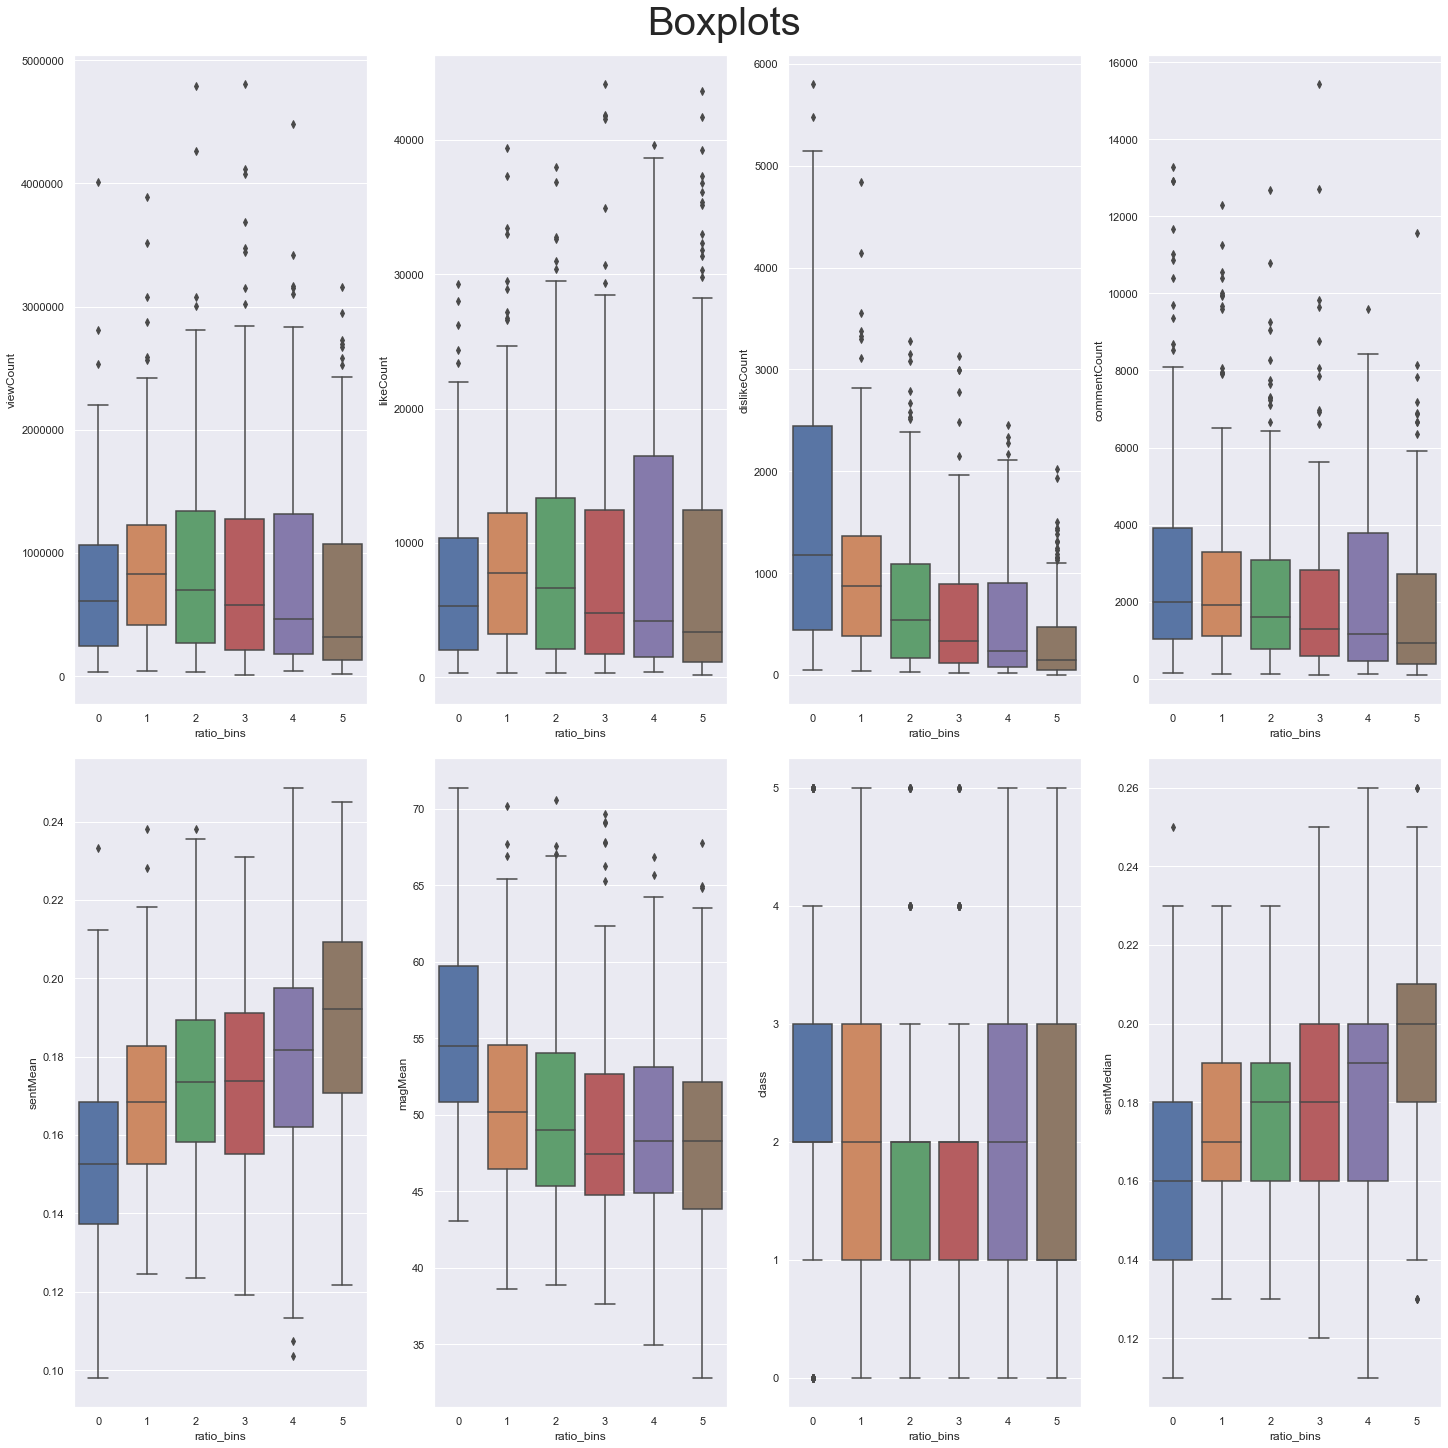

In [257]:
parameters = ['viewCount','likeCount','dislikeCount','commentCount','sentMean','magMean','class','sentMedian']
fig,axes = plt.subplots(2, 4, sharex=False, sharey=False,figsize = (20,20),constrained_layout=True)
plt.suptitle('Boxplots', size='40')
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='ratio_bins',y=parameters[i],data=vids,ax=ax)

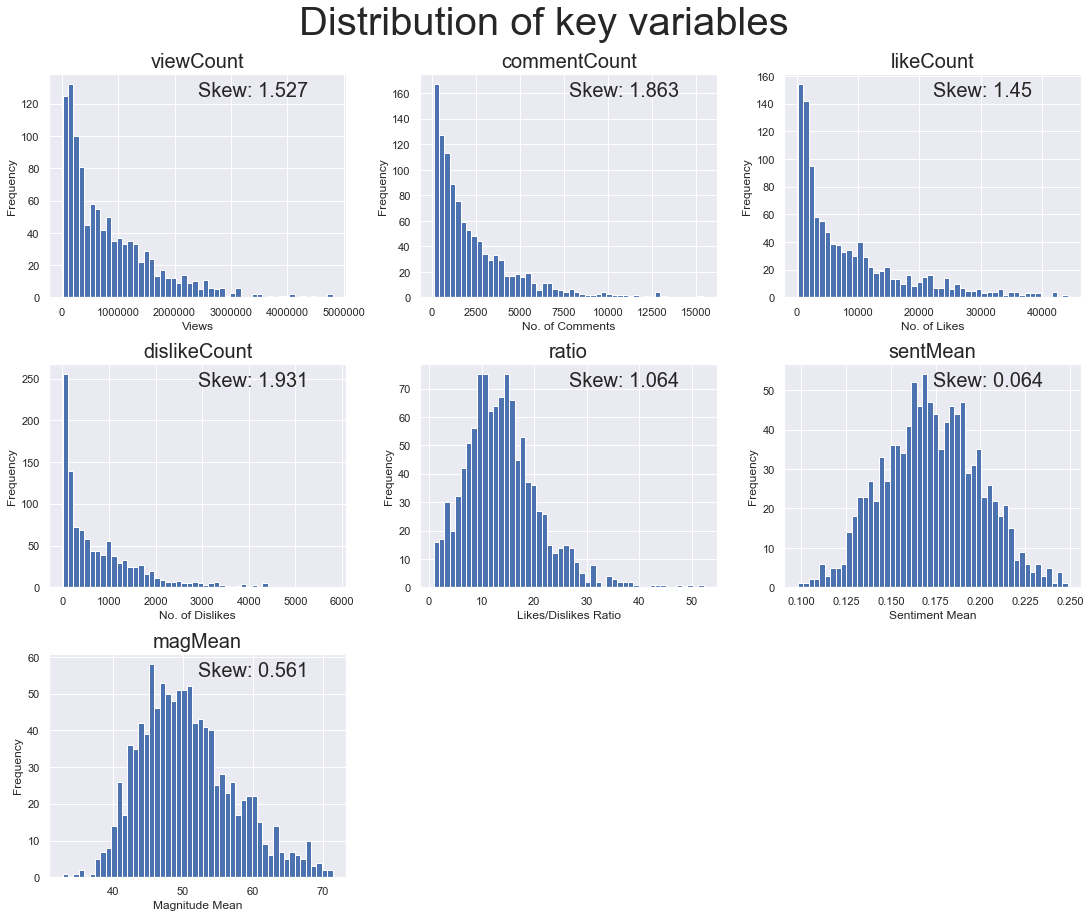

In [258]:
cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','ratio','sentMean',
              'magMean']
x_label_list = ['Views','No. of Comments','No. of Likes','No. of Dislikes',
                'Likes/Dislikes Ratio','Sentiment Mean','Magnitude Mean']

fig,axes = plt.subplots(3, 3, sharex=False, sharey=False,figsize = (15,12),constrained_layout=True)
fig.suptitle('Distribution of key variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])


for i, ax in enumerate(axes.flat):
    if i > 6:
        break
    vids[cols[i]].hist(ax=ax,bins=50)
    skew = ('Skew: ' + str(round(vids[cols[i]].skew(),3)))
    ax.annotate(skew, xy = (0.5, 0.9), size = 20, xycoords = ax.transAxes)
    ax.set_title(cols[i], size=20)
    ax.set_xlabel(x_label_list[i])
    ax.set_ylabel('Frequency')

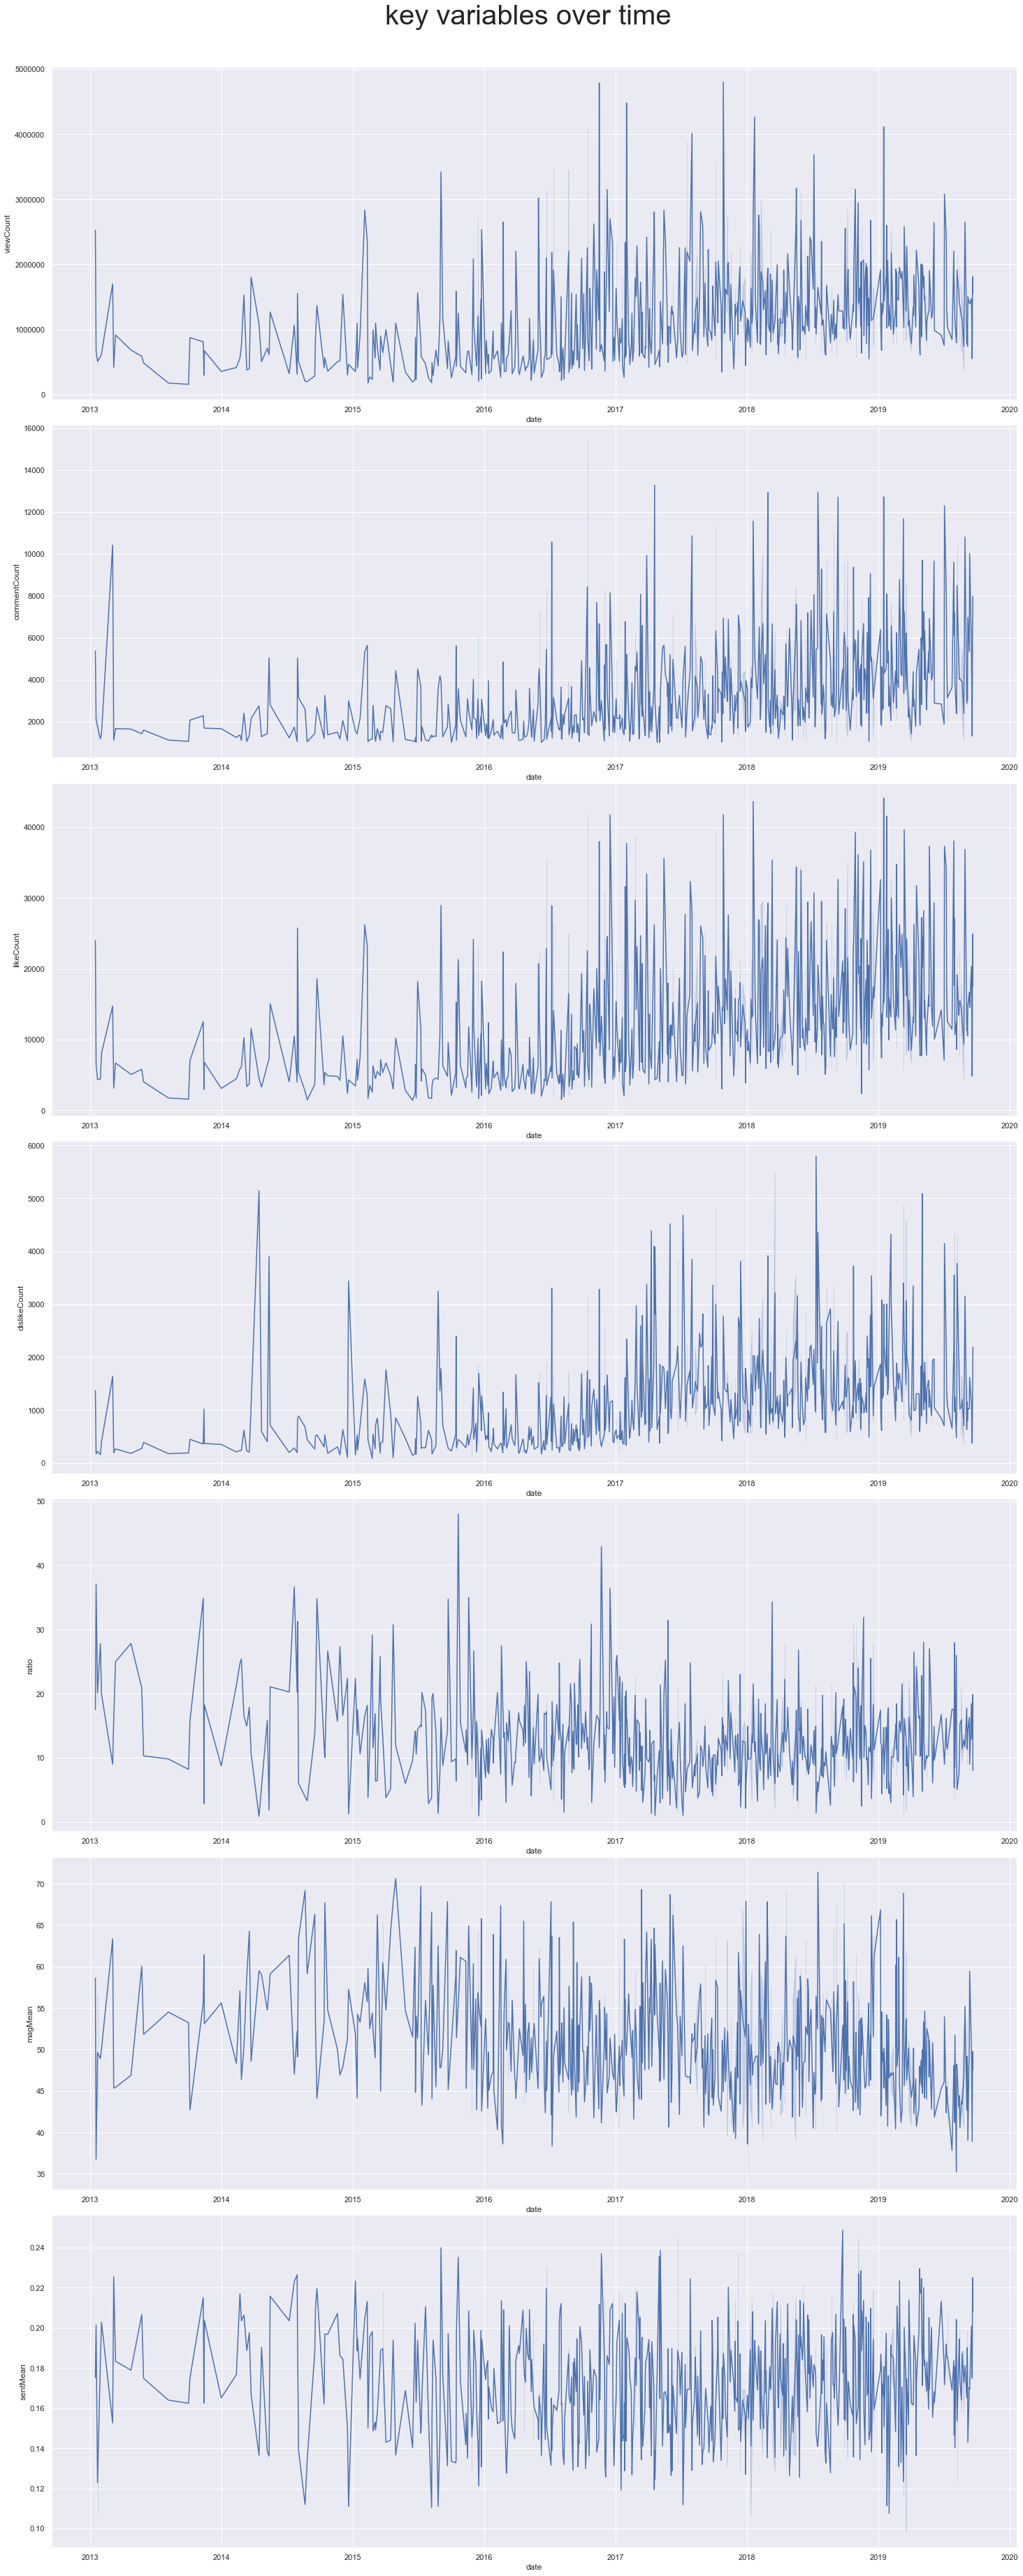

In [253]:
cols = ['viewCount','commentCount','likeCount','dislikeCount','ratio','magMean','sentMean']
titleList = ['views','comment count','likes and dislikes','ratio','magnitude mean','sentiment mean']

fig,axes = plt.subplots(len(cols), 1, sharex=False, sharey=False,figsize = (20,50))
plt.tight_layout()
fig.suptitle('key variables over time', size='40',y=1.02)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=plotting_df,x=plotting_df.index,y=cols[i],ax=ax)

Text(0.5, 1, 'ratio heatmap with key variables\n')

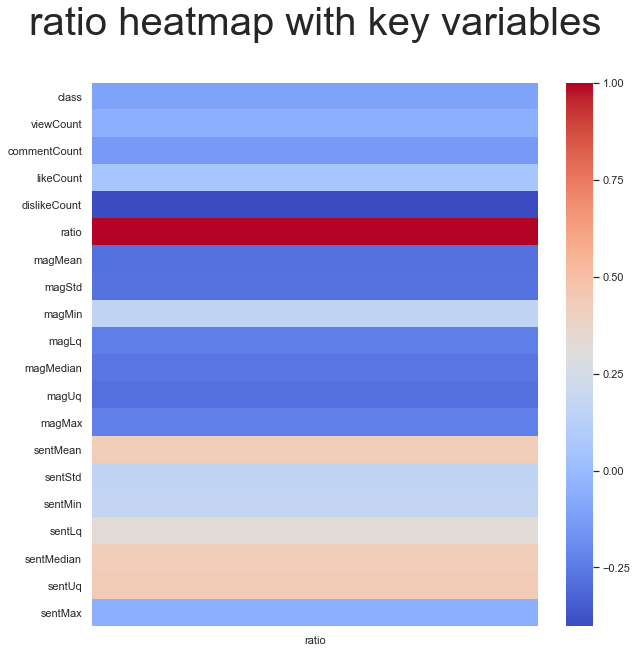

In [259]:
plt.figure(figsize=(10,10))
ratio_correlation = vids.corr().ratio
sns.heatmap(ratio_correlation.to_frame(),cmap = 'coolwarm')
plt.title('ratio heatmap with key variables\n',size=40)

## Bivariate analysis

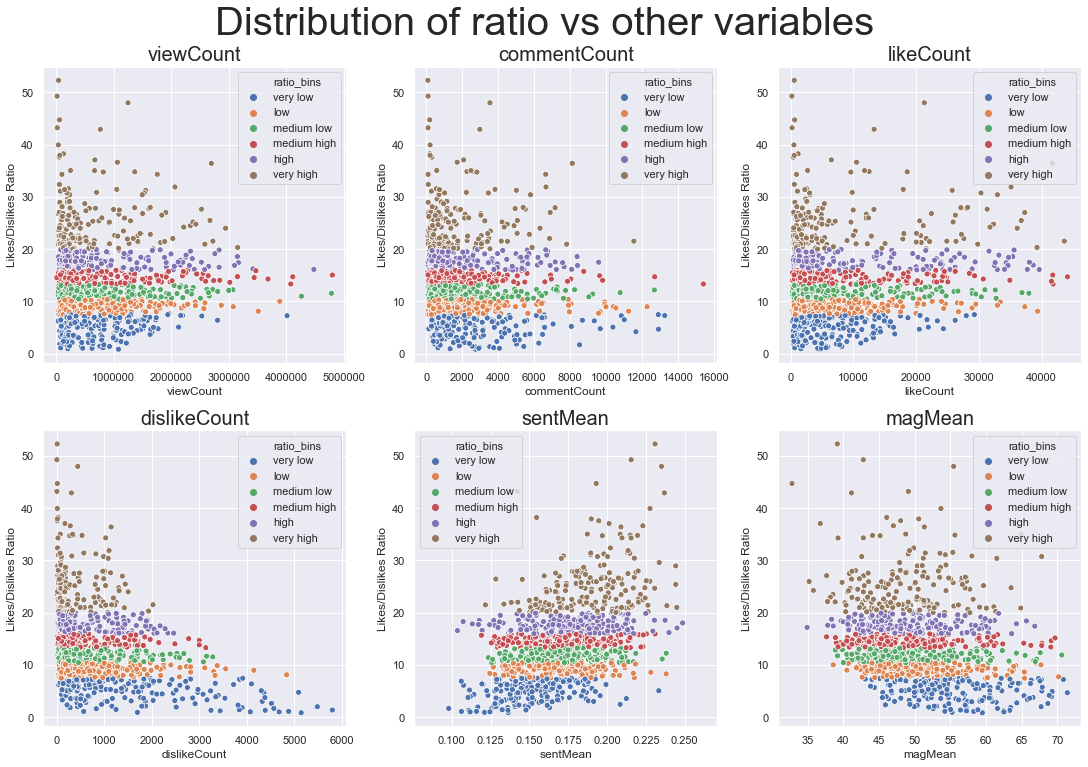

In [261]:
plotting_df = vids
bin_labels = ['very low','low','medium low','medium high','high','very high']
plotting_df['ratio_bins'] = pd.qcut(plotting_df['ratio'], q=6, labels = bin_labels)
#basic visualisation of ratio between sentiment and ratio
fig,axes = plt.subplots(2, 3, sharex=False, sharey=False,figsize = (15,10), constrained_layout=True)

cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','sentMean','magMean']

fig.suptitle('Distribution of ratio vs other variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()


for i, ax in enumerate(axes.flat):
    sns.scatterplot(data=plotting_df, x=cols[i], y="ratio", hue='ratio_bins',ax=ax)
    ax.set_title(cols[i], size=20)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Likes/Dislikes Ratio')

In [263]:
def corr(x, y, **kwargs):
    
    coef = np.corrcoef(x, y)[0][1]
    label = str(round(coef, 2))
    
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.33), size = 50, xycoords = ax.transAxes)

Text(0.5, 1.05, 'Pairgrid of key variables\n')

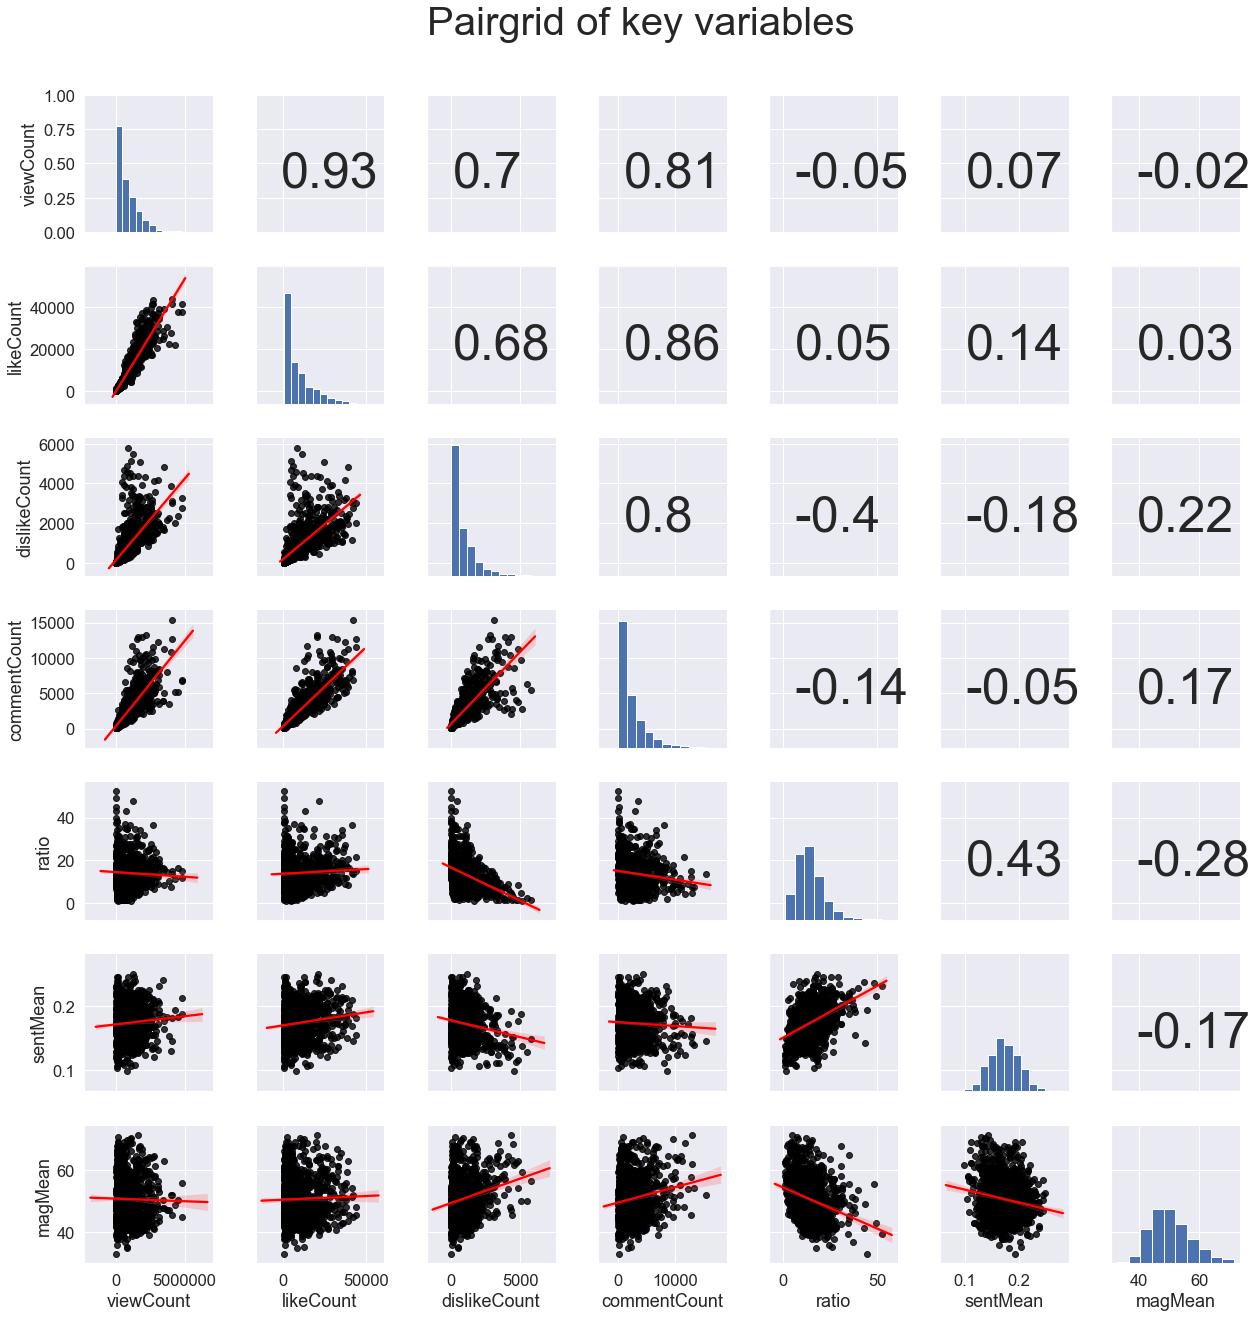

In [267]:
params = ['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'ratio', 'sentMean', 'magMean']

sns.set(font_scale=1.5)
g = sns.PairGrid(vids[params])
g = g.map_lower(sns.regplot,line_kws={"color": "red"}, scatter_kws={'color':'black'})
g = g.map_diag(plt.hist)
g = g.map_upper(corr)
plt.suptitle('Pairgrid of key variables\n',size='40', y=1.05)

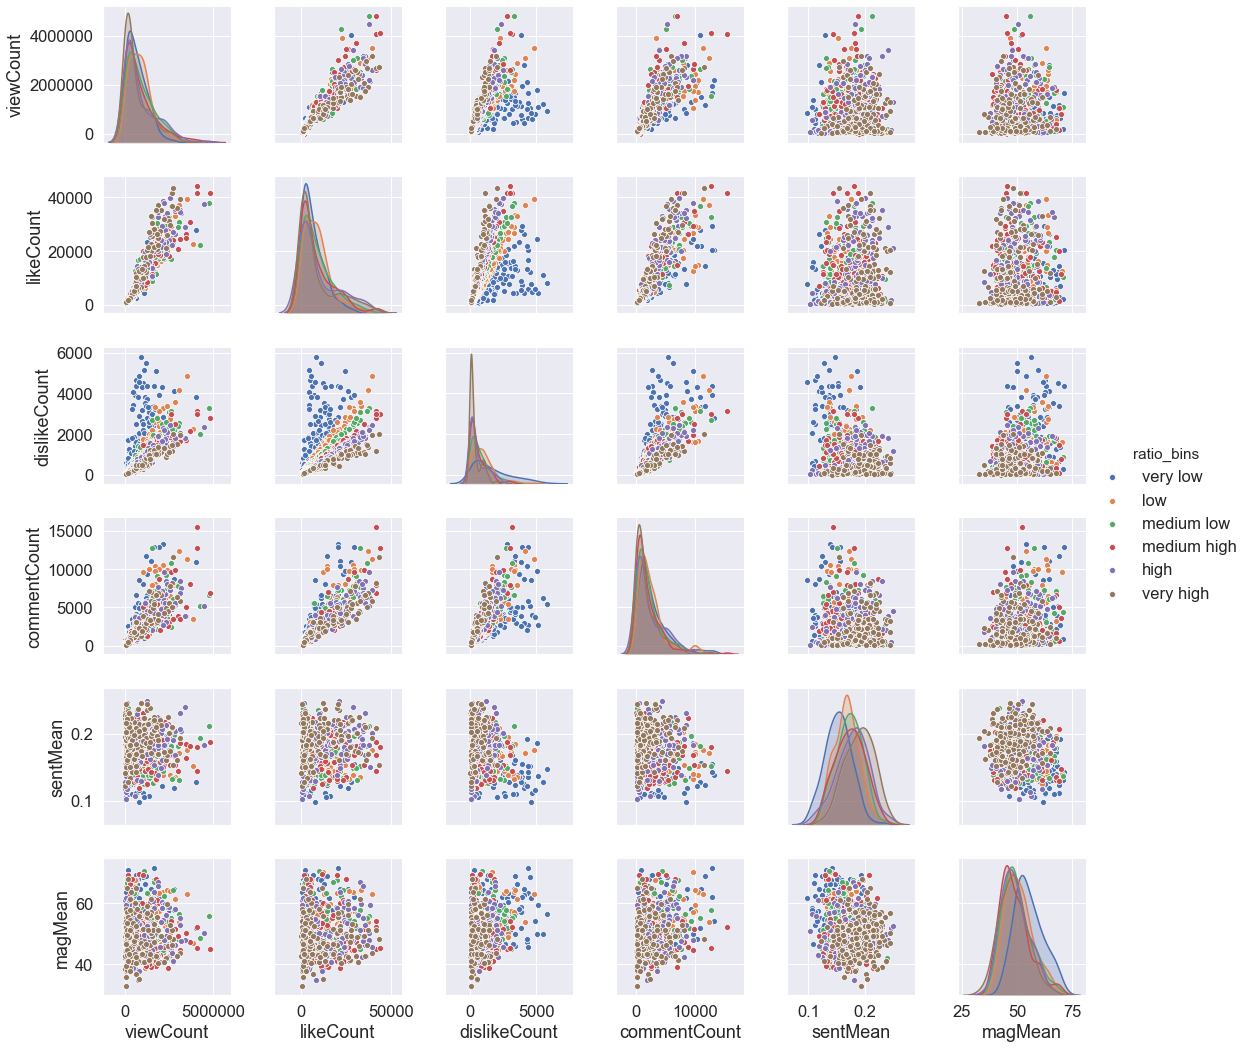

In [266]:
sns.pairplot(vids, vars=['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'sentMean', 'magMean'], hue='ratio_bins')

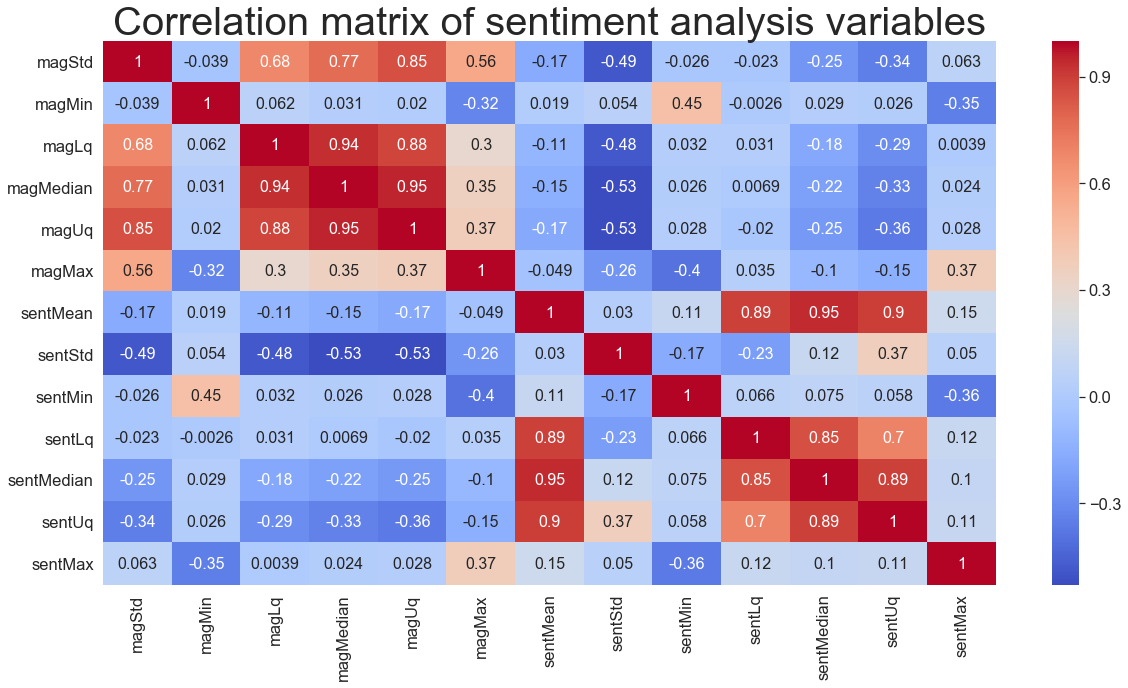

In [277]:
param = vids.columns[9:]
corr = vids[param]
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of sentiment analysis variables', size=40)
sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":16})

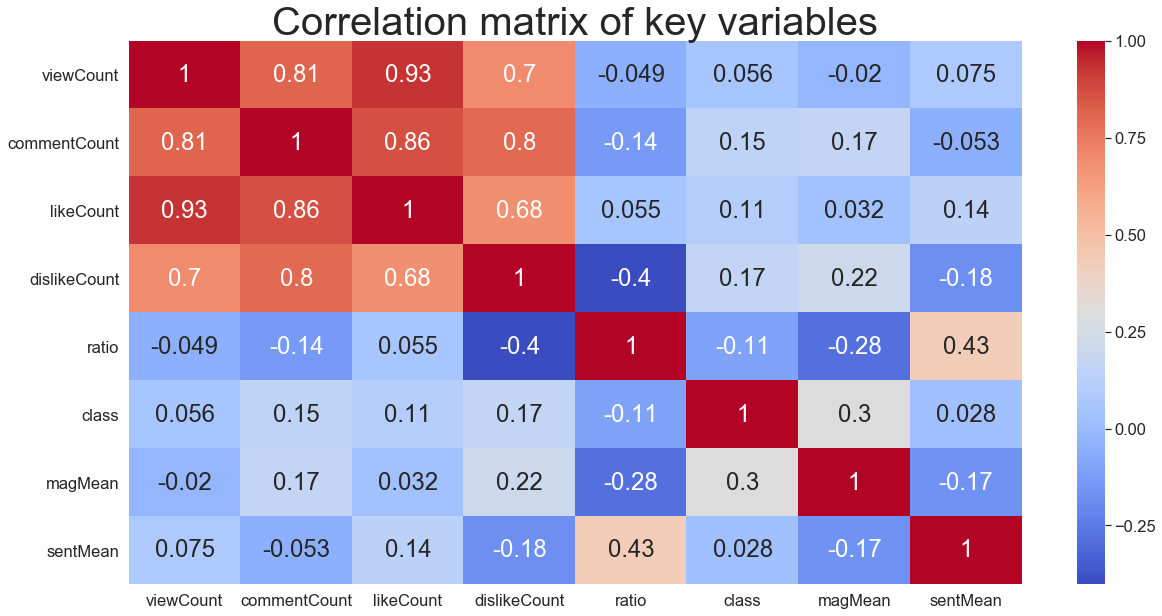

In [276]:
param = ['viewCount','commentCount','likeCount','dislikeCount','ratio','class','magMean','sentMean']
corr = vids[param]

plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of key variables', size=40)

sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":24})